# Exploring Environmental Complaints in Chicago

An in-depth analysis and predictive modeling of environmental complaints in Chicago, utilizing historical data to identify trends, spatial distributions, and forecast future complaints. This project employs machine learning techniques to categorize complaints by type and uses time series forecasting to predict complaint volumes, aiming to aid in more effective resource allocation and response strategies for addressing urban environmental concerns."


In [7]:
import pandas as pd
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import contextily as ctx
import geopandas as gpd
import seaborn as sns
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

In [77]:
complaints_df = pd.read_csv('CDPH_Environmental_Complaints_20240404.csv')
complaints_df['COMPLAINT TYPE'] = complaints_df['COMPLAINT TYPE'].str.upper() #some of the complaint type categories are the same, but in different case 
complaints_df = complaints_df.drop(columns='Modified Date')

#(complaints_df['COMPLAINT DATE'] > start_date) & (complaints_df['COMPLAINT DATE']<= end_date)
#complaints_df.head()
#complaints_df


## Spatial Distribution of Specific Complaint Types 

This visualization presents the distribution of environmental complaints in Chicago, categorized by complaint type. The dataset spans complaints received by the Department of Environment (DOE) from January 1993 to December 31, 2011, and by the Department of Public Health (CDPH) since January 1, 2012. The transition of responsibilities from DOE to CDPH in 2012 marks a pivotal shift in the management of environmental complaints, which is reflected in  analysis and visualization. 

* The complaints data was first converted into a GeoDataFrame, enabling spatial analysis and visualization capabilities. Each point on the map represents a complaint, color-coded by its type to easily distinguish the variety of complaints managed by the authorities.

* To enhance the context of the analysis, complaint points on a basemap of Chicago are overlaid. This approach helps in understanding the geographical distribution of complaints across different neighborhoods and identifying potential hotspots for specific types of environmental issues.

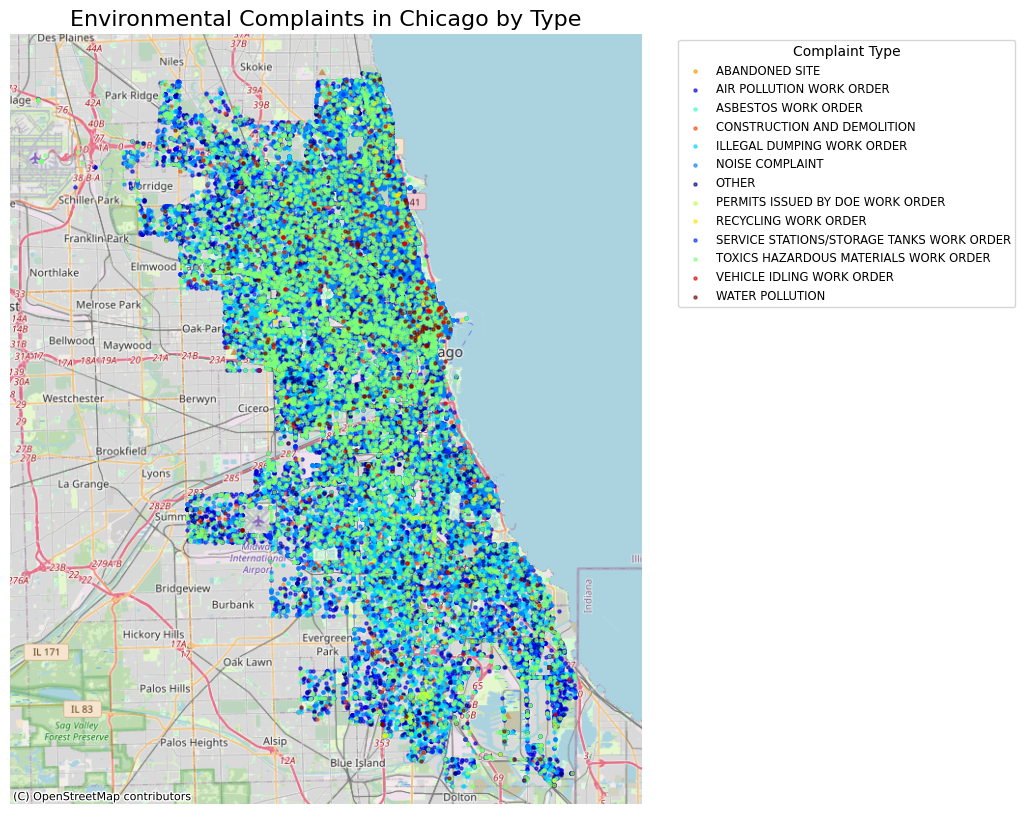

In [78]:
# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(
    complaints_df.drop(['LATITUDE', 'LONGITUDE'], axis=1),
    geometry=gpd.points_from_xy(complaints_df.LONGITUDE, complaints_df.LATITUDE),
    crs="EPSG:4326"
)

# # Generate a color for each unique complaint type
complaint_types = gdf['COMPLAINT TYPE'].unique()
colors = plt.cm.jet(np.linspace(0, 1, len(complaint_types)))
color_dict = dict(zip(complaint_types, colors))

# # Add a 'color' column to your GeoDataFrame
gdf['color'] = gdf['COMPLAINT TYPE'].map(color_dict)


# Convert GeoDataFrame to Web Mercator (needed for most basemap services)
gdf = gdf.to_crs(epsg=3857)


fig, ax = plt.subplots(figsize=(10, 10))

# Plotting each complaint type with its respective color
for ctype, data in gdf.groupby('COMPLAINT TYPE'):
    color = color_dict[ctype]
    data.plot(ax=ax, marker='o', color=color, markersize=5, alpha=0.6, label=ctype)

#center coordinates of Chicago in EPSG:3857
chicago_center_x = -9763000
chicago_center_y = 5137000

# Defining a zoom extent (the size of the view box)
half_width = 25000
half_height = 30500
extent = [chicago_center_x - half_width, chicago_center_x + half_width, 
          chicago_center_y - half_height, chicago_center_y + half_height]

# Set the extent
ax.set_xlim(extent[0:2])
ax.set_ylim(extent[2:4])

# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Removing axis for cleaner look
ax.set_axis_off()

# Adding a legend outside the plot
ax.legend(title='Complaint Type', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

plt.title('Environmental Complaints in Chicago by Type', fontsize=16)
plt.show()


### Insights

Complaint Distribution: The map vividly illustrates the spread of environmental complaints throughout Chicago. By color-coding the complaints, we can immediately identify areas with higher concentrations of specific complaint types.

While this map focuses on the spatial aspect, it's important to note the historical context of the dataset. The shift of responsibility from DOE to CDPH in 2012 might influence the types and volumes of complaints recorded, an aspect worth exploring in further temporal analyses.

Geospatial analysis of environmental complaints can be a crucial tool for urban planning and policy making. Identifying areas with frequent complaints can guide targeted interventions and resource allocation to address environmental issues effectively.

### Technical Details
The visualization leverages GeoPandas for spatial data handling and Matplotlib and Contextily for plotting. Complaints are plotted on a Stamen Toner Lite basemap, providing a clear, unobtrusive background that emphasizes the complaint data. The map is centered around Chicago, using a fixed extent to zoom in on the central area and ensure focus on the urban landscape where complaints are concentrated.

***

## Yearly Trends of Complaint Types: Analyze how different types of complaints have trended over the years. 
This can help in understanding if certain types of complaints are becoming more common or if there have been improvements in specific areas.

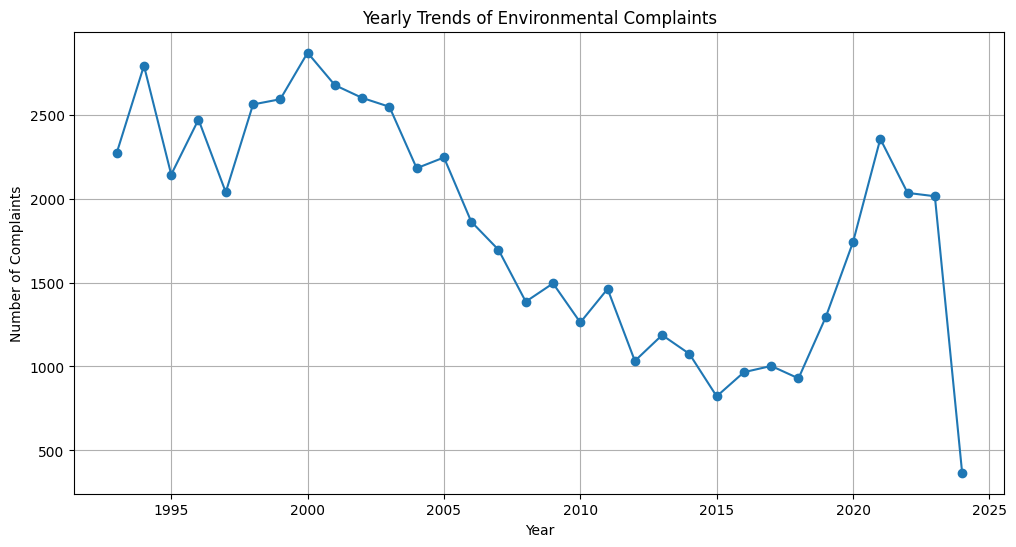

In [79]:
# Convert 'COMPLAINT DATE' to datetime format
complaints_df['COMPLAINT DATE'] = pd.to_datetime(complaints_df['COMPLAINT DATE'])

# Extract year from 'COMPLAINT DATE'
complaints_df['YEAR'] = complaints_df['COMPLAINT DATE'].dt.year

# Count the number of complaints per year
yearly_complaints = complaints_df.groupby('YEAR').size()

# Plotting
plt.figure(figsize=(12, 6))
yearly_complaints.plot(kind='line', marker='o')
plt.title('Yearly Trends of Environmental Complaints')
plt.xlabel('Year')
plt.ylabel('Number of Complaints')
plt.grid(True)
plt.show()


## Complaint Types Breakdown

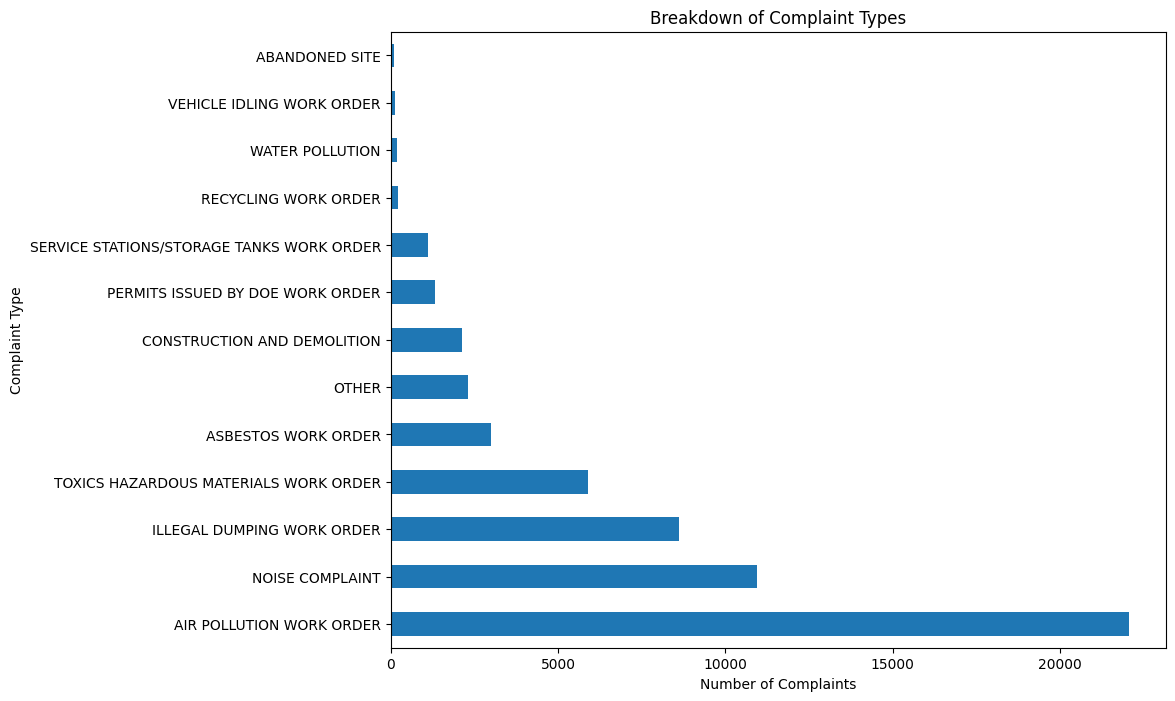

In [11]:
# Complaint types breakdown
complaint_types = complaints_df['COMPLAINT TYPE'].value_counts()

# Plotting
plt.figure(figsize=(10, 8))
complaint_types.plot(kind='barh')
plt.title('Breakdown of Complaint Types')
plt.xlabel('Number of Complaints')
plt.ylabel('Complaint Type')
plt.show()


*** 
<br/>

## Predicting Complaint Types

Building a simple classifier to predict the type of complaint based on features like the complaint detail text, location, and time of year. This could automatically categorize complaints as they come in, streamlining the response process.

### Feature Engineering:

**Text Features:** NLP to vectorize the "COMPLAINT DETAIL" text.<br/>
**Time Features:** Extract features from "COMPLAINT DATE", such as month or season.<br/>
**Location Features:** "LATITUDE" and "LONGITUDE" directly, or cluster areas to simplify.<br/>

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

# Filter out rows where complaint detail or type might be missing
df_filtered = complaints_df.dropna(subset=['COMPLAINT DETAIL', 'COMPLAINT TYPE'])

# Preparing the dataset
X = df_filtered['COMPLAINT DETAIL']
y = df_filtered['COMPLAINT TYPE']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a model pipeline
model = make_pipeline(TfidfVectorizer(), MultinomialNB())

# Training the model
model.fit(X_train, y_train)

# Predicting the test set
y_pred = model.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))


                                           precision    recall  f1-score   support

                           ABANDONED SITE       0.00      0.00      0.00        16
                 AIR POLLUTION WORK ORDER       0.62      0.98      0.76      3905
                      ASBESTOS WORK ORDER       1.00      0.28      0.44       566
              CONSTRUCTION AND DEMOLITION       0.00      0.00      0.00       252
               ILLEGAL DUMPING WORK ORDER       0.74      0.69      0.72      1664
                          NOISE COMPLAINT       0.97      0.85      0.90      1940
                                    OTHER       1.00      0.02      0.03       445
         PERMITS ISSUED BY DOE WORK ORDER       1.00      0.13      0.23       256
                     RECYCLING WORK ORDER       0.00      0.00      0.00        32
SERVICE STATIONS/STORAGE TANKS WORK ORDER       1.00      0.03      0.05       226
    TOXICS HAZARDOUS MATERIALS WORK ORDER       0.82      0.63      0.71      1142
   

* **Data Imbalance:** The varying performance across different complaint types suggests a potential imbalance in the training data. Some complaint types like "Air Pollution Work Order" are much more common, which can lead to the model being biased towards predicting these more frequent classes. Techniques such as oversampling, undersampling, or synthetic data generation (SMOTE) could help address this imbalance.

* **Feature Engineering:** The disparities in performance also hint at the need for more nuanced feature engineering. Incorporating additional features or exploring different text vectorization techniques (beyond TF-IDF) might help, especially for less frequent complaint types.

### Model Adjustment 

#### Key Changes Explained:

* **Data Encoding:** The target variable (COMPLAINT TYPE) is encoded to numerical values to be compatible with SMOTE and the model.

* **SMOTE for Imbalance:** We applied SMOTE to the training data to handle the imbalance issue. This generates synthetic examples for minority classes, aiming for a balanced dataset.

* **Model Switch:** Switched from Naive Bayes to Logistic Regression, which might handle the high-dimensional sparse data from TfidfVectorizer more effectively and can be more robust to the imbalance in the data.

* **Pipeline Adjustment:** The standard make_pipeline is replaced with make_pipeline_imb from imblearn to accommodate SMOTE in the pipeline. However, due to the complexity of incorporating TfidfVectorizer directly into the imblearn pipeline with text data, vectorization is handled outside the pipeline.

In [13]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

# Assuming complaints_df is your DataFrame

# Filter out rows where complaint detail or type might be missing
df_filtered = complaints_df.dropna(subset=['COMPLAINT DETAIL', 'COMPLAINT TYPE'])

# Preparing the dataset
X = df_filtered['COMPLAINT DETAIL']
y = df_filtered['COMPLAINT TYPE']

# Encoding the target variable since SMOTE needs numerical values
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Splitting the dataset
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Vectorizing text data
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Addressing the data imbalance with SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train_tfidf, y_train_encoded)

# Using a more complex model: Logistic Regression
model = LogisticRegression(max_iter=1000)

# Training the model on the resampled data
model.fit(X_res, y_res)

# Predicting the test set
y_pred_encoded = model.predict(X_test_tfidf)

# Decoding the predictions back to original labels
y_pred = le.inverse_transform(y_pred_encoded)
y_test = le.inverse_transform(y_test_encoded)

# Evaluation
print(classification_report(y_test, y_pred))


                                           precision    recall  f1-score   support

                           ABANDONED SITE       0.33      0.62      0.43        16
                 AIR POLLUTION WORK ORDER       0.91      0.83      0.87      3905
                      ASBESTOS WORK ORDER       0.95      0.93      0.94       566
              CONSTRUCTION AND DEMOLITION       0.47      0.74      0.57       252
               ILLEGAL DUMPING WORK ORDER       0.82      0.76      0.79      1664
                          NOISE COMPLAINT       0.95      0.94      0.94      1940
                                    OTHER       0.46      0.59      0.52       445
         PERMITS ISSUED BY DOE WORK ORDER       0.56      0.77      0.65       256
                     RECYCLING WORK ORDER       0.68      0.84      0.75        32
SERVICE STATIONS/STORAGE TANKS WORK ORDER       0.67      0.81      0.73       226
    TOXICS HAZARDOUS MATERIALS WORK ORDER       0.78      0.79      0.78      1142
   

**The updated model results show a significant improvement in predicting the types of environmental complaints compared to the initial Naive Bayes model.**

#### Overall Performance
* Accuracy has increased to 78%, indicating that the model now correctly predicts the complaint type for nearly four out of every five complaints. This is a notable improvement from the initial model.

* Macro Average scores across precision, recall, and F1-score have improved, indicating a more balanced performance across all classes, not just the dominant ones.

* Weighted Average scores are also high, reflecting the model's effectiveness across the dataset, taking into account the imbalanced nature of the complaint types.

#### Performance by Complaint Type
* **Improved Detection of Rare Complaints:** Classes such as "ABANDONED SITE" and "PERMITS ISSUED BY DOE WORK ORDER" have seen significant improvements in precision and recall, indicating the model's increased ability to identify even those complaint types with fewer instances.

* **Balanced Performance in Major Categories:** For major complaint types like "Air Pollution Work Order" and "Noise Complaint," the model maintains high precision and recall. This balance is crucial for practical applications, ensuring that the system is reliable across the most common types of complaints.

* **High Precision and Recall in Specific Categories:** Categories like "Asbestos Work Order" show exceptionally high precision and recall, suggesting that the model can very accurately identify and classify these complaints.
Challenges with Less Frequent Categories: Despite improvements, some categories, like "WATER POLLUTION," still show a precision or recall of 0.00, indicating challenges in predicting very rare complaint types. This could be due to very few training instances or features that are not distinct enough from those of other complaint types.

#### Key Takeaways
* **Data Imbalance Handling:** The use of SMOTE for addressing data imbalance has likely contributed significantly to improving the model's ability to detect less frequent complaint types, as evidenced by increased recall scores across many previously underperforming categories.

* **Model Complexity:** Switching to Logistic Regression from Naive Bayes, along with optimized feature engineering (TF-IDF vectorization), has enhanced the model's predictive capacity, particularly in distinguishing between different types of complaints based on complaint details.

* **Need for Continuous Improvement:** While the improvements are substantial, the persistence of low scores in a few categories suggests room for further model refinement, possibly through more advanced NLP techniques or incorporating additional contextual features.

<br/>

*** 

## Time Series Forecasting

### Aggregate Complaints by Month

In [14]:
# Aggregating complaints by month
complaints_df['YEAR_MONTH'] = complaints_df['COMPLAINT DATE'].dt.to_period('M')
monthly_complaints = complaints_df.groupby('YEAR_MONTH').size()


### Analyze the Time Series

Before fitting an ARIMA model, analyze the montly complaints over time to better understand the characteristics of the time series (trends, seasonality, and autocorrelation). 

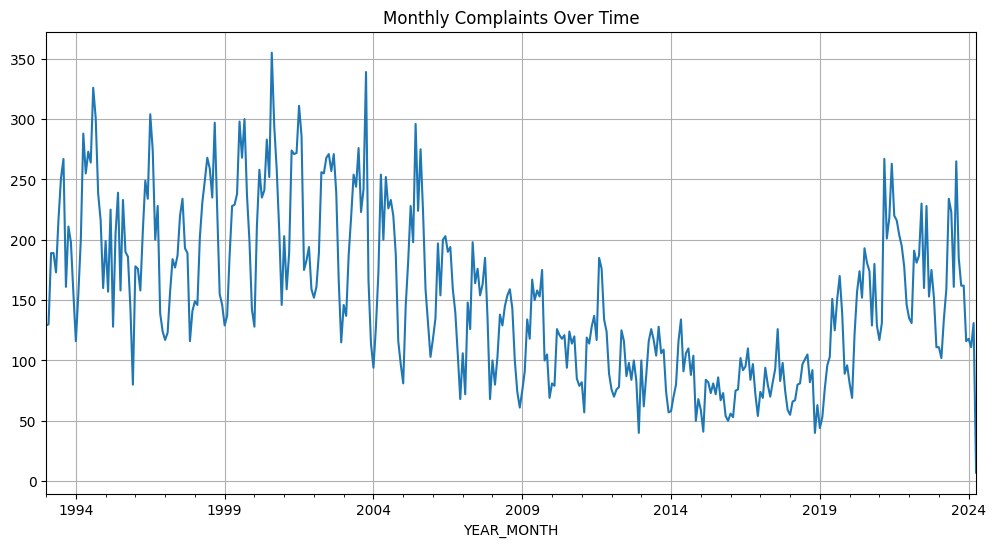

In [15]:
monthly_complaints.plot(figsize=(12, 6), title='Monthly Complaints Over Time')
plt.grid(True)
plt.show()


### ARIMA Model
pmdarima library to automatically select the best ARIMA parameters (p, d, q) for model.

In [16]:
from pmdarima import auto_arima
import matplotlib.pyplot as plt

# Automatically find optimal order for the ARIMA model
auto_model = auto_arima(monthly_complaints, seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True)

auto_model.summary()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=3661.311, Time=1.78 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3836.449, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3752.680, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3771.723, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3834.474, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=3775.736, Time=0.82 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=3717.294, Time=0.98 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=inf, Time=3.10 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=inf, Time=3.72 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=3821.931, Time=0.15 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=3731.140, Time=2.45 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=inf, Time=2.45 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=3.63 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=i

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  376
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood               -1820.831
Date:                              Thu, 04 Apr 2024   AIC                           3653.662
Time:                                      20:44:19   BIC                           3677.224
Sample:                                  01-31-1993   HQIC                          3663.016
                                       - 04-30-2024                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7719      0.147      5.256      0.000       0.484       1.060
ma.L1         -1.3755      0.165     -8.311      0.000      -1.700      -1.051
ma.L2          0.4221      0.131      3.228      0.001       0.166       0.678
ar.S.L12       0.9877      0.008    116.682      0.000       0.971       1.004
ma.S.L12      -0.8464      0.050    -16.974      0.000      -0.944      -0.749
sigma2       923.6647     48.497     19.046      0.000     828.612    1018.718
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):               122.38
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                             0.03
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Seasonal Patterns and Trends
The significant seasonal component (ar.S.L12 and ma.S.L12) of the model suggests that there are clear seasonal trends in the environmental complaints data. This could reflect seasonal variations in environmental factors (e.g., more complaints about air quality in summer due to higher ozone levels, or increased complaints about noise during warmer months when windows are more likely to be open).
The strong autoregressive component (ar.L1) indicates that the number of complaints in a given month is closely related to the number in the previous month, highlighting a short-term continuity in complaint volumes.

### Model Diagnostics and Data Insights
The diagnostics, including the Ljung-Box test and heteroskedasticity test, suggest that while the model fits the data well overall (with residuals being independently distributed), there are concerns about the normality and variance of residuals. This could indicate complex underlying patterns not fully captured by the model, potentially due to unmodeled factors that influence complaint volumes (e.g., specific events, policy changes, or external environmental factors).<br/>
The presence of heteroskedasticity (variable variance in residuals over time) could point to periods of increased variability in complaint numbers, which might be associated with external events or changes in the city’s environment or policies.

### Model Limitations
The Jarque-Bera test indicates that the residuals do not follow a normal distribution, which might affect the model’s predictive accuracy. Exploring data transformations or more complex models could help address this issue.<br/>
Considering additional variables (such as weather data, population density changes, or environmental policy changes) in the model could improve its accuracy and explanatory power, offering richer insights into the drivers of environmental complaints in Chicago.

### Conclusion 
Overall, the SARIMAX model provides valuable insights into the temporal dynamics of environmental complaints in Chicago, highlighting the impact of seasonal patterns and the continuity of complaint volumes over time. By forecasting future complaints, the model aids in better planning and resource allocation, although some model diagnostics suggest areas for further refinement to enhance the model's performance and accuracy.

### Forcasting

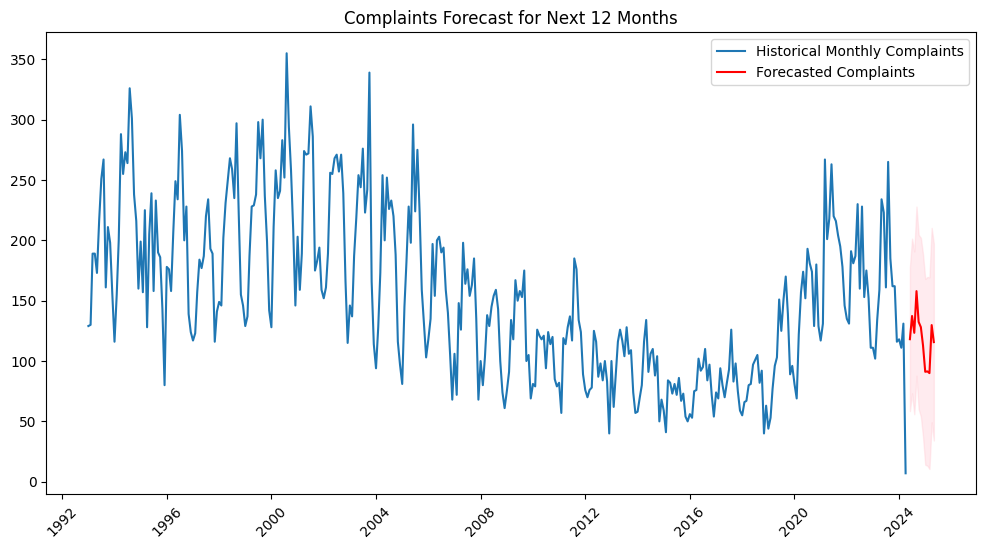

In [17]:
# Convert PeriodIndex to DateTimeIndex
monthly_complaints.index = monthly_complaints.index.to_timestamp()

# Forecast the next 12 months
forecast, conf_int = auto_model.predict(n_periods=12, return_conf_int=True)

# Generating future dates starting after the last date in monthly_complaints
future_dates = pd.date_range(start=monthly_complaints.index[-1], periods=13, freq='M')[1:]

# Plotting the forecast with the corrected index
plt.figure(figsize=(12, 6))
plt.plot(monthly_complaints.index, monthly_complaints, label='Historical Monthly Complaints')
plt.plot(future_dates, forecast, color='red', label='Forecasted Complaints')
plt.fill_between(future_dates, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3)
plt.title('Complaints Forecast for Next 12 Months')
plt.xticks(rotation=45) 
plt.legend()
plt.show()

*** 

## Conclusion 
* To predict the future trend of environmental complaints, ARIMA model was utilized, which is particularly suited for time series data. This model helps understand the underlying patterns in the monthly complaint data and forecast future complaints.

* The forecasting plot shows historical data along with the predicted values for the next 12 months. The shaded area represents the confidence interval for forecasts, giving a range of expected values.

## Observations and Next Steps

* The forecast provides a quantifiable estimate that can aid in resource planning and allocation for handling future complaints.

* It's important to periodically retrain the model with new data to maintain its accuracy.

* Further refinement of the model might include exploring more sophisticated time series models or incorporating external variables that could impact complaint volume (e.g., weather data, population growth).

* By continuously monitoring and analyzing complaint trends, policymakers and public health officials can proactively address environmental issues and improve community well-being.